# ALY 6980 - Capstone Project

Group: Sayli Bahekar, Emily Z. Fan, Yanru Chen 
Instructor: Prof. Shanu Sushmita
Northeastern University - CPS Analytics


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
from matplotlib.pyplot import figure

from sklearn.metrics import mean_squared_error
import math
from math import sqrt

%matplotlib inline

In [ ]:
#Read the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Data= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Forecasting_dataset.csv')

In [ ]:
# Extract month and year datetime value
Data['placed_at']= pd.to_datetime(Data['placed_at'])
Data["Order_Month"] = pd.DatetimeIndex(Data['placed_at']).month
Data["Order_Year"] = pd.DatetimeIndex(Data['placed_at']).year

Data["Date"] = pd.DatetimeIndex(Data['placed_at']).date
Data['month_year'] = pd.to_datetime(Data['placed_at']).dt.to_period('M')
Data['month_year'] = Data['month_year'].astype(str)
Data['month_year'] = pd.to_datetime(Data['month_year'])
Data["Total Price per order"] = Data["qty"] * Data["price"]

### Data Pre-processing

In [ ]:
#remove records with missing values
Data = Data.dropna(axis=0, subset=['top_cat_id'])

#Removing 2 outlier categories
Data = Data.query("qty < 3600000")

Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336459 entries, 0 to 336471
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     336459 non-null  int64         
 1   order_id               336459 non-null  int64         
 2   placed_at              336459 non-null  datetime64[ns]
 3   placed_at_time         336459 non-null  object        
 4   merchant_id            336459 non-null  int64         
 5   sku_id                 336459 non-null  int64         
 6   top_cat_id             336459 non-null  float64       
 7   top_cat_name           336459 non-null  object        
 8   sub_cat_id             336459 non-null  float64       
 9   qty                    336459 non-null  int64         
 10  price                  336459 non-null  float64       
 11  Order_Month            336459 non-null  int64         
 12  Order_Year             336459 non-null  int6

### Feature Engineering

Creating new dataset - datewise demands

In [ ]:
def Data_for_ARIMA(Data_1):
  grouped_multiple = Data_1.groupby(['Date']).agg({'qty': ['sum']})
  grouped_multiple.columns = ['Total Quantity']
  grouped_multiple = grouped_multiple.reset_index()

  Data_qty = grouped_multiple

  #Series data
  Data_ts = Data_qty.set_index('Date')
  return Data_ts;

split training and test sets

In [ ]:
# split into train and test sets
def Train_Test_ARIMA(Data_ts_1):
  X = Data_ts_1.values
  size = int(len(X) * 0.7)
  train, test = X[0:size], X[size:len(X)]
  history = [x for x in train]

  predictions = list()
  return history, test, predictions

### Modeling

Model Building

model 1: ARIMA

In [ ]:
# evaluate an ARIMA model using a walk-forward validation
from statsmodels.tsa.arima.model import ARIMA

def ARIMA_Model(history, test, predictions):
		# walk-forward validation
	for t in range(len(test)):
				model = ARIMA(history, order=(5,1,0)).fit(method_kwargs={"warn_convergence": False})
				#model_fit = model.fit()
				output = model.forecast()
				yhat = output[0]
				predictions.append(yhat)
				obs = test[t]
				history.append(obs)
				#print('predicted=%f, expected=%f' % (yhat, obs))
	rmse = sqrt(mean_squared_error(test, predictions))
 
	print('\nTest RMSE = %.3f' % rmse)
	plt.figure(figsize=(15,8))
	plt.plot(test)
	plt.plot(predictions, color='red')
	#plt.legend()
	plt.show()
	return model

Forecasting for individual SKU based on the user's choice.

Forecasting for all data - Press 1 
Forecasting for specific category - press 2 
Forecasting for specific SKU ID - press 3 
 ->1
1
ARIMA Model for all data:



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



Test RMSE = 119893.499


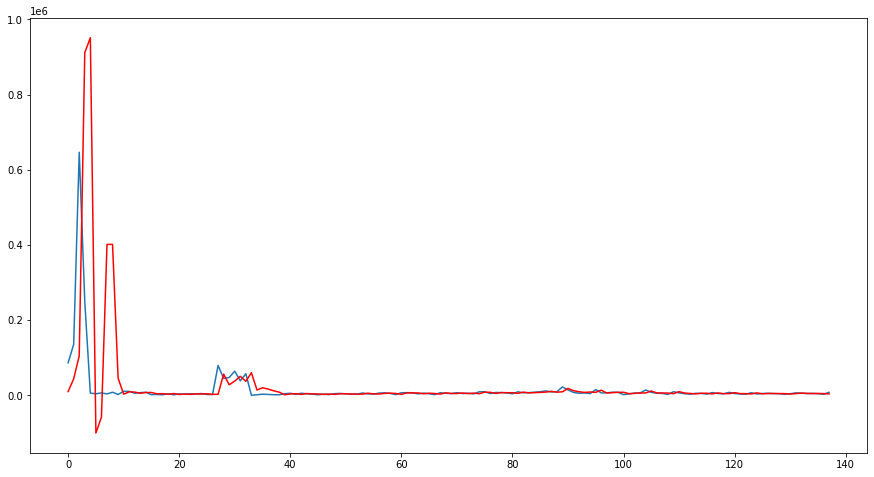

In [ ]:
Choice = int(input("Forecasting for all data - Press 1 \nForecasting for specific category - press 2 \nForecasting for specific SKU ID - press 3 \n ->"))
print(Choice)
if Choice == 1:
  Data_ts = Data_for_ARIMA(Data)
  history, test, predictions = Train_Test_ARIMA(Data_ts)
  print("ARIMA Model for all data:\n")
  ARIMA_Model(history, test, predictions)
elif Choice == 2:
  Cat = float(input("Enter Category ID : "))
  Data_cat= Data.query("`top_cat_id` == @Cat")
  Data_ts = Data_for_ARIMA(Data_cat)
  history, test, predictions = Train_Test_ARIMA(Data_ts)
  print("ARIMA Model for top_cat_id:",Cat)
  ARIMA_Model(history, test, predictions)
elif Choice == 3:
  SKU = float(input("Enter SKU ID : "))
  Data_sku= Data.query("`sku_id` == @SKU")
  Data_ts = Data_for_ARIMA(Data_sku)
  history, test, predictions = Train_Test_ARIMA(Data_ts)
  print("ARIMA Model for SKU:", SKU)
  ARIMA_Model(history, test, predictions)
else:
  print("Enter Correct choice")

model 2: Neural Network

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

t_onthot = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ["top_cat_id","Order_Month"]),], remainder='passthrough') 
# Default is to drop untransformed columns

t_pass_through = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), []),], remainder='passthrough') 
# Default is to drop untransformed columns

One-hot Encoding

In [ ]:
Data_selected = Data[["merchant_id", "sku_id", "top_cat_id", "sub_cat_id", "price", "Order_Month", "Order_Year"]]

data_onehot=t_onthot.fit_transform(Data_selected)
data_pass_through=t_pass_through.fit_transform(Data_selected)

In [ ]:
X_onehot=data_onehot
X_pass = data_pass_through
y=Data[["qty"]].to_numpy().flatten()

In [ ]:
X_train_onehot, X_test_onehot, y_train, y_test = train_test_split(X_onehot, y, random_state=1, train_size=0.7)

In [ ]:
# regr = MLPRegressor(hidden_layer_sizes=(64), learning_rate_init=0.5, tol=0.01, random_state=2, max_iter=50, verbose=True).fit(X_train, y_train)
regr_onehot = MLPRegressor(max_iter=5, verbose=True).fit(X_train_onehot, y_train)

Iteration 1, loss = 2433551.75351161
Iteration 2, loss = 236399.91594362
Iteration 3, loss = 197525.39629488
Iteration 4, loss = 192630.30255083
Iteration 5, loss = 715121.62376334


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
X_train_pass, X_test_pass, y_train, y_test = train_test_split(X_pass, y, random_state=1, train_size=0.7)
regr = MLPRegressor(max_iter=5, verbose=True).fit(X_train_pass, y_train)

Iteration 1, loss = 10149105.84128859
Iteration 2, loss = 201419.65172737
Iteration 3, loss = 197126.42135924
Iteration 4, loss = 195322.96145209
Iteration 5, loss = 192105.00077188


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
print('Coefficient with Onehot Encoding: ', regr_onehot.score(X_test_onehot, y_test))
print('RMSE with Onehot Encoding: ', mean_squared_error(y_test, regr_onehot.predict(X_test_onehot)))

print('\nCoefficient : ', regr.score(X_test_pass, y_test))
print('RMSE with Onehot Encoding: ', mean_squared_error(y_test, regr.predict(X_test_pass)))

Coefficient with Onehot Encoding:  0.21819470389702467
RMSE with Onehot Encoding:  62236.1065988647

Coefficient :  0.2141892658513077
RMSE with Onehot Encoding:  62554.96203567356


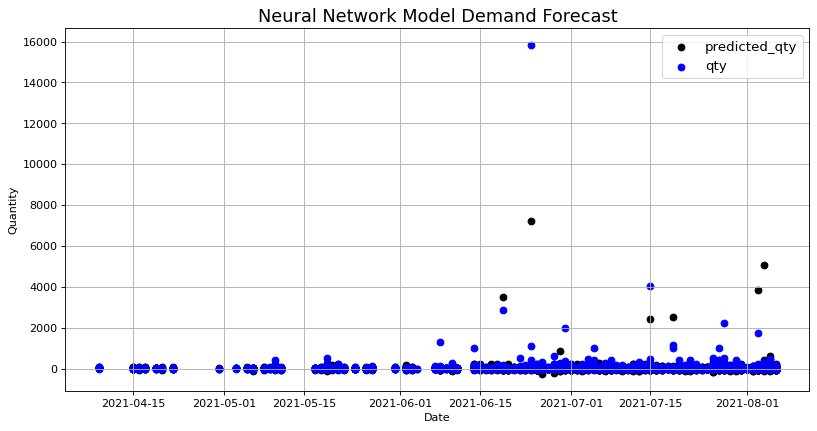

In [ ]:
fig = figure(figsize=(12, 6), dpi=80)
# fig.add_axes([0.5, 1, 0.5, 1])

px = Data["placed_at"]
# black is prediction value, blue is true label
plt.scatter(px[:10000], regr_onehot.predict(X_test_onehot)[:10000], color="black", linewidth=1, label='predicted_qty')
plt.scatter(px[:10000], y_test[:10000], color="blue", linewidth=1, label='qty')

# plt.xticks(())
# plt.yticks(())
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend(prop={'size': 12})
plt.grid(True)
plt.title("Neural Network Model Demand Forecast",fontdict={'fontsize': 16})

plt.show()
# in this task, we train a neural network deep learning model which takes
#"merchant_id", "sku_id", "top_cat_id", "sub_cat_id", "Order_Month", "Order_Year" as input and predicts qty (demand) as output.

# from the chart and above MSE metric and corrleation we can see this neural network deep learning model has a resonable prediction performance.
# There is still improvement space if we have enough computing resource and time we could do one-hot for all categorical features. 
# Also, we need to accumalte more data to train a meaningful model

model 3: weekly aggregation

Datetime Components

In [ ]:
#sale quantaties in weekly intervals
def weekly(df):
  df=Data
  df['Week'] = pd.to_datetime(df['Date']) - pd.to_timedelta(7, unit='d')
  df = df.groupby([pd.Grouper(key='Week', freq='W-Fri'),'sku_id', 'top_cat_id'])['qty'].agg(sum).to_frame().reset_index()
  df.rename(columns={"qty": "Total Quantity"}, inplace=True)
  return df;

def weekly_data(df):
  #df=Data
  df['Week'] = pd.to_datetime(df['Date']) - pd.to_timedelta(7, unit='d')
  df = df.groupby([pd.Grouper(key='Week', freq='W-Fri')])['qty'].agg(sum).to_frame().reset_index()
  df.rename(columns={"qty": "Total Quantity"}, inplace=True)
  df_week = df.set_index('Week')
  return df_week

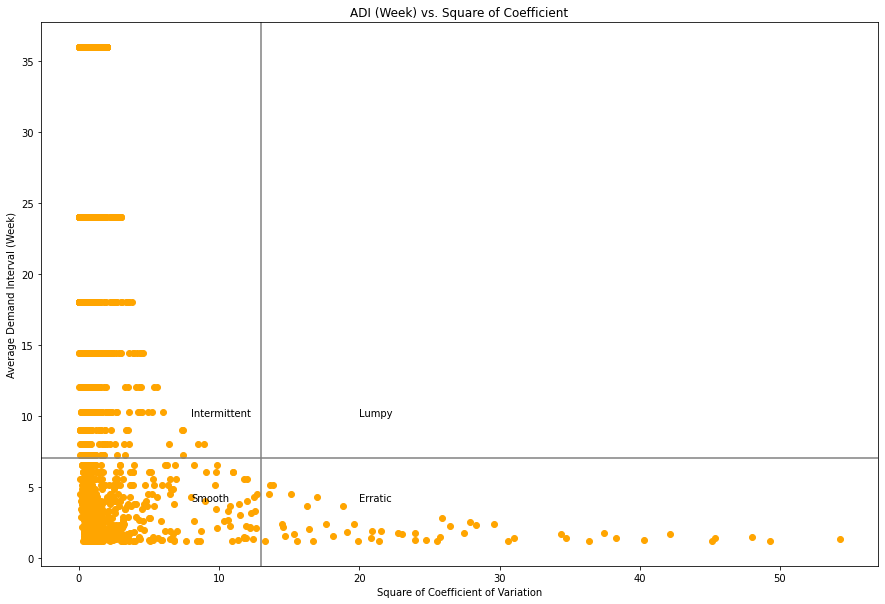

In [ ]:
#def sku_classify():
m3=weekly(Data).pivot_table(index='sku_id', columns='Week', values='Total Quantity',aggfunc='sum')

# Average Demand Interval (ADI)
ADI = len(m3.columns) / m3.count(axis=1)

# Square of the Coefficient of Variation (COV)
cov = lambda x: np.square(np.std(x, ddof=1) / np.mean(x))
CV2 = m3.apply(cov,axis=1)

m3['ADI'] = ADI
m3['CV2'] = CV2

plt.figure(figsize=(15,10))
plt.scatter(CV2, ADI, color='orange')
plt.title('ADI (Week) vs. Square of Coefficient')
plt.xlabel('Square of Coefficient of Variation')
plt.ylabel('Average Demand Interval (Week)')
plt.axhline(y=7, linewidth=1.5, color='grey')
plt.axvline(x=13, linewidth=1.5, color='grey')
plt.text(8, 4, "Smooth")
plt.text(20, 4, "Erratic")
plt.text(8, 10, "Intermittent")
plt.text(20, 10, "Lumpy")
plt.show()
#sku_classify()

In [ ]:
smooth = m3.query('`CV2` < 13 and `ADI` < 7').index.tolist()
erratic = m3.query('`CV2` >= 13 and `ADI` < 7').index.tolist()
intermittent = m3.query('`CV2` < 13 and `ADI` >= 7').index.tolist()
# There is no lumpy demand SKU

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error, max_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_autocorrect(sku):
  df_week = weekly(Data).pivot_table(index='Week', columns='sku_id', values='Total Quantity', aggfunc='sum')
  print('\nWeekly sales amount Autocorrelation Plots')
  plot_acf(df_week[sku], lags=30, title="Autocorrelation of smooth demand, Weekly sales")
  plot_pacf(df_week[sku], lags=30, title="Partial Autocorrelation of Smooth demand Weekly sales")

def smooth_baseline():
  Data_ts = Data_for_ARIMA(Data.loc[Data["sku_id"].isin(smooth)])
  history, test, predictions = Train_Test_ARIMA(Data_ts)
  print("\nPrediction evaluation for Smooth Demand:\n")
  ARIMA_Model(history, test, predictions)
  print('\nR2 score = %.3f' % r2_score(test, predictions), '\nMax error = %.3f' % max_error(test, predictions))
 
  y_baseline_pred = np.empty(len(test))
  y_baseline_pred.fill(np.mean(test))

  RMSE_baseline = sqrt(mean_squared_error(test, y_baseline_pred))
  print('\nBaseline model: \nRMSE = %.3f' % RMSE_baseline, 
        '\nR2 score = %.3f' % r2_score(test, y_baseline_pred), 
        '\nMax error = %.3f' % max_error(test, y_baseline_pred))


def plot_nn(df):
  fig = figure(figsize=(14, 10), dpi=80)
  px = df["placed_at"]
  plt.scatter(px[:1000], nn.predict(X_test)[:1000], color="black", linewidth=1, label='predicted_qty')
  plt.scatter(px[:1000], y_test[:1000], color="blue", linewidth=1, label='qty')
  plt.xlabel("Date")
  plt.ylabel("Quantity")
  plt.legend(prop={'size': 16})
  plt.grid(True)
  plt.title("Sales Amount Forecast", fontdict={'fontsize': 18})
  plt.show()
  
def nn_partial(df):
  Data_sku_classified = Data.loc[Data["sku_id"].isin(df)]
  X = t_pass_through.fit_transform(Data_sku_classified[["merchant_id", "sku_id", "top_cat_id", "price", "Order_Month", "Order_Year"]])
  y = Data_sku_classified[["qty"]].to_numpy().flatten()
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, train_size=0.7)
  nn = MLPRegressor(max_iter = 100, verbose = True, activation='relu').fit(X_train, y_train)
  RMSE = sqrt(mean_squared_error(y_test, nn.predict(X_test)))
  print('\nMLP NN model: \nRMSE = %.3f' % RMSE, '\nR2 score = %.3f' % r2_score(y_test, nn.predict(X_test)), '\nMax error = %.3f' % max_error(y_test, nn.predict(X_test)))
  #plot_nn(Data.query("`sku_id` == @SKU_Classified")) 


  y_baseline_pred = np.empty(len(y_test))
  y_baseline_pred.fill(np.mean(y_test))

  RMSE_baseline = sqrt(mean_squared_error(y_test, y_baseline_pred))
  print('\nBaseline model: \nRMSE = %.3f' % RMSE_baseline, 
        '\nR2 score = %.3f' % r2_score(y_test, y_baseline_pred), 
        '\nMax error = %.3f' % max_error(y_test, y_baseline_pred)) 

In [ ]:
SKU_Classified = float(input("Enter SKU ID : "))

if SKU_Classified in smooth:
  Data_sku_classified = Data.query("`sku_id` == @SKU_Classified")
  Data_ts = weekly_data(Data_sku_classified)
  history, test, predictions = Train_Test_ARIMA(Data_ts)
  print("\nSKU {} is a Smooth Demand. Prediction evaluation for SKU {} is: ".format(SKU_Classified, SKU_Classified))
  ARIMA_Model(history, test, predictions)
  print('\nR2 score = %.3f' % r2_score(test, predictions), '\nMax error = %.3f' % max_error(test, predictions))
  plot_autocorrect(SKU_Classified)
  smooth_baseline()

elif SKU_Classified in erratic:
  nn_partial(erratic)
  print("\nSKU {} is a Erratic Demand".format(SKU_Classified))

  #plot_nn(Data.query("`sku_id` == @SKU_Classified"))  

elif SKU_Classified in intermittent:  
  nn_partial(intermittent)  
  print("\nSKU {} is a Intermittent Demand".format(SKU_Classified))


Enter SKU ID : 332
Iteration 1, loss = 2485426.18138081
Iteration 2, loss = 2156443.36926094
Iteration 3, loss = 2132752.28902968
Iteration 4, loss = 2111324.57239299
Iteration 5, loss = 2098116.53060221
Iteration 6, loss = 2084280.43856430
Iteration 7, loss = 2065355.26973821
Iteration 8, loss = 2051657.94873490
Iteration 9, loss = 2036996.98830925
Iteration 10, loss = 2024804.87660265
Iteration 11, loss = 2011996.37133648
Iteration 12, loss = 2111180.69296838
Iteration 13, loss = 2184932.18150678
Iteration 14, loss = 2017603.03244504
Iteration 15, loss = 1975041.79466790
Iteration 16, loss = 1965689.45459323
Iteration 17, loss = 1956479.53623356
Iteration 18, loss = 1947882.98892582
Iteration 19, loss = 1942974.93638540
Iteration 20, loss = 1937469.25974316
Iteration 21, loss = 1927860.71745538
Iteration 22, loss = 1928599.57591814
Iteration 23, loss = 1916547.24025592
Iteration 24, loss = 1910932.74300782
Iteration 25, loss = 1923237.81390443
Iteration 26, loss = 1899301.49806431
It

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


### Evaluation

In [ ]:
Data_ts = Data_for_ARIMA(Data)
history, test, predictions = Train_Test_ARIMA(Data_ts)
ARIMA_Model(history, test, predictions)
  
y_baseline_m1 = np.empty(len(test))
y_baseline_m1.fill(np.mean(test))

print('ARIMA RMSE = ', sqrt(mean_squared_error(test, predictions)))
print('\nARIMA RMSE_baseline = ', sqrt(mean_squared_error(test, y_baseline_m1)))

ARIMA RMSE =  119893.49941009433

ARIMA RMSE_baseline =  60009.465022526696


In [ ]:
y_baseline_predict = np.empty(len(y_test))
y_baseline_predict.fill(np.mean(y_test))

print('NN RMSE_baseline = ', sqrt(mean_squared_error(y_test, y_baseline_predict)))
print('\nNN RMSE with one hot encoding = ', sqrt(mean_squared_error(y_test, regr_onehot.predict(X_test_onehot))))

NN RMSE_baseline =  282.14470477464323

NN RMSE with one hot encoding =  249.47165490064137
